In [145]:
# import needed package
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt

import torch as t
import numpy as np
import torchvision
from torch import nn
import torchvision.transforms as transforms
import time
from torch.nn import init
from tqdm import tqdm
import sys
sys.path.append("..") # 为了导⼊上层⽬录的d2lzh_pytorch
import d2lzh_pytorch as d2l


### 数读取和探析

In [2]:
# pytorch处理的数据为tensor类型
mnist_train = torchvision.datasets.FashionMNIST(root="./data/"
                                                , train=True
                                                , download=True
                                                , transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root="./data/"
                                               , train=False
                                               , download=True
                                               , transform=transforms.ToTensor())

In [3]:
# 数据大小
len(mnist_train)

60000

In [19]:
# img size
mnist_train[0][0].size()

torch.Size([1, 28, 28])

In [6]:
# label 
mnist_train[0][1]

9

In [20]:
# 显示label
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress',
    'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    
    return [text_labels[int(i)] for i in labels]

In [26]:
# 显示标签和图片
def show_fashion_mnist(images, labels):
    """显示图片"""
    fig, axs = plt.subplots(1, len(labels), figsize=(12, 12))
    for ax, img, label in zip(axs, images, labels):
        ax.imshow(img.view(28, 28).numpy())
        ax.set_title(label)
        # 设置边框不可见
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    plt.savefig("./imgs/visiual_img.png")
    plt.show()

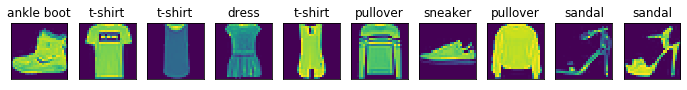

In [27]:
X = []
Y = []
for i  in range(10):
    X.append(mnist_train[i][0])
    Y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(Y))

In [23]:
## 小批量的读取数据
batch_size = 256
num_workers = 4

train_iter = torch.utils.data.DataLoader(mnist_train,
batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test,
batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [34]:
# 计算时间
for i, (img, label) in enumerate(tqdm(train_iter)):
    continue

100%|██████████| 235/235 [00:03<00:00, 66.34it/s]


###  SOFTMAX回归的从零开始实现

In [72]:
# 参数的初始化
num_inputs = 784
num_outputs = 10
W = t.tensor(np.random.normal(0, 0.01, (num_inputs,
num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [73]:
# 定义softmax 网络
def softmax(X):
    X_exp = X.exp()
    # dim = 1 行
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp/partition

In [83]:
X = t.rand((2, 5), dtype=t.float)
print("Softmax:", softmax(X))
print("Max:", t.max(softmax(X), dim = 1))

Softmax: tensor([[0.1867, 0.2107, 0.2411, 0.2190, 0.1425],
        [0.1712, 0.1910, 0.1848, 0.1363, 0.3167]])
Max: torch.return_types.max(
values=tensor([0.2411, 0.3167]),
indices=tensor([2, 4]))


In [84]:
# 定义网络
def net(x):
    return softmax(torch.mm(x.view(-1, num_inputs), W) + b)    

In [ ]:
t.gather()

In [85]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [86]:
y.view(-1, 1)

tensor([[0],
        [2]])

In [88]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

In [102]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [103]:
print(accuracy(y_hat, y))

0.5


In [106]:
# 准确率的使用
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum/n

In [107]:
print(evaluate_accuracy(test_iter, net))

0.0555


In [128]:
# 可视化数据
def plot(X, y, name):
    plt.plot(X, y)
    plt.xlabel("epoch")
    plt.ylabel(name)
    plt.savefig("./imgs/"+name+".png")
    plt.show()

In [160]:
## 训练
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None
          , optimizer = None):
    test_acc = []
    train_acc = []
    train_loss = []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            # 计算loss
            l = loss(y_hat, y).sum()
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.zero_()
            
            # 计算梯度
            l.backward()
            # 梯度更新
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()
                
            # 计算train loss
            train_l_sum += l.item()
            
            #train accuracy
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        train_loss.append(train_l_sum/n)
        train_acc.append((train_acc_sum / n))
        test_acc.append(evaluate_accuracy(test_iter, net))
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_loss[epoch], train_acc[epoch],
test_acc[epoch]))
    
    # 可视化
    plot(range(num_epochs), train_loss, name="train_loss")
    plot(range(num_epochs), train_acc, name="train_acc")
    plot(range(num_epochs), test_acc, name="test_acc")  

epoch 1, loss 0.3990, train acc 0.863, test acc 0.845
epoch 2, loss 0.3984, train acc 0.864, test acc 0.844
epoch 3, loss 0.3987, train acc 0.863, test acc 0.844
epoch 4, loss 0.3972, train acc 0.864, test acc 0.840
epoch 5, loss 0.3970, train acc 0.864, test acc 0.846
epoch 6, loss 0.3962, train acc 0.864, test acc 0.843
epoch 7, loss 0.3960, train acc 0.864, test acc 0.845
epoch 8, loss 0.3951, train acc 0.864, test acc 0.844
epoch 9, loss 0.3951, train acc 0.865, test acc 0.841
epoch 10, loss 0.3945, train acc 0.865, test acc 0.841
epoch 11, loss 0.3934, train acc 0.865, test acc 0.845
epoch 12, loss 0.3943, train acc 0.865, test acc 0.843
epoch 13, loss 0.3930, train acc 0.865, test acc 0.843
epoch 14, loss 0.3931, train acc 0.865, test acc 0.845
epoch 15, loss 0.3920, train acc 0.864, test acc 0.845
epoch 16, loss 0.3922, train acc 0.865, test acc 0.844
epoch 17, loss 0.3909, train acc 0.865, test acc 0.844
epoch 18, loss 0.3910, train acc 0.866, test acc 0.845
epoch 19, loss 0.39

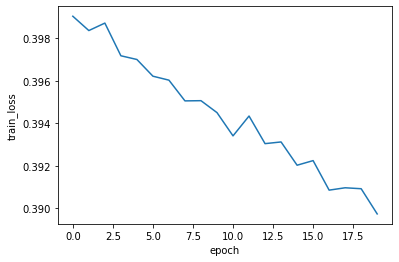

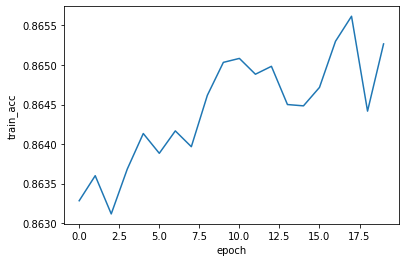

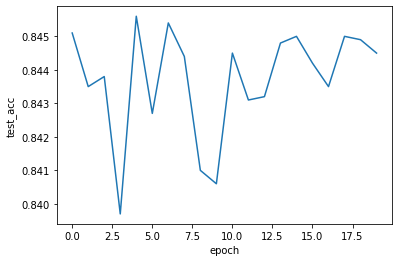

In [130]:
num_epochs, lr = 20, 0.1
train(net, train_iter, test_iter, cross_entropy, num_epochs,
batch_size, [W, b], lr)

256


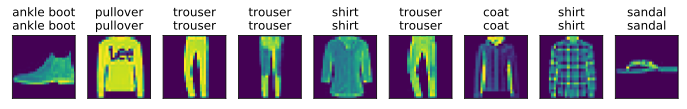

In [139]:
# 预测
X, y = iter(test_iter).next()
print(len(X))
true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())

titles = [true + '\n' + pred for true, pred in zip(true_labels,
pred_labels)]
d2l.show_fashion_mnist(X[0:9], titles[0:9])

### Pytorch版本的SOFTMAX

In [155]:
# 定义一个网络

class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        
    def forward(self, x):
        return self.linear(x.view(x.shape[0], -1))
net = LinearNet()

# 参数初始化
init.normal_(net.linear.weight, mean=0.0, std=0.01)
init.constant_(net.linear.bias, val=0.0)

## 训练
lr = 0.01
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(net.parameters(), lr=lr)
train_loss = []
for epoch in range(num_epochs):
    for i, (img, label) in (enumerate(train_iter)):
        label_hat = net(img)
        loss = criterion(label_hat, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss.append(loss.item())
    print("loss is:", loss.item())

loss is: 1.0836294889450073
loss is: 0.9752967953681946
loss is: 0.78707355260849
loss is: 0.663398802280426
loss is: 0.6977536678314209
loss is: 0.7109480500221252
loss is: 0.8682286739349365
loss is: 0.6021382212638855
loss is: 0.541563868522644
loss is: 0.7092130184173584


epoch 1, loss 0.0019, train acc 0.836, test acc 0.824
epoch 2, loss 0.0019, train acc 0.837, test acc 0.825
epoch 3, loss 0.0019, train acc 0.838, test acc 0.826
epoch 4, loss 0.0019, train acc 0.838, test acc 0.825
epoch 5, loss 0.0019, train acc 0.838, test acc 0.827
epoch 6, loss 0.0019, train acc 0.839, test acc 0.825
epoch 7, loss 0.0019, train acc 0.839, test acc 0.826
epoch 8, loss 0.0019, train acc 0.840, test acc 0.827
epoch 9, loss 0.0019, train acc 0.840, test acc 0.828
epoch 10, loss 0.0019, train acc 0.840, test acc 0.828
epoch 11, loss 0.0019, train acc 0.841, test acc 0.828
epoch 12, loss 0.0019, train acc 0.841, test acc 0.828
epoch 13, loss 0.0019, train acc 0.841, test acc 0.829
epoch 14, loss 0.0019, train acc 0.841, test acc 0.829
epoch 15, loss 0.0019, train acc 0.842, test acc 0.829
epoch 16, loss 0.0019, train acc 0.842, test acc 0.830
epoch 17, loss 0.0018, train acc 0.842, test acc 0.830
epoch 18, loss 0.0018, train acc 0.843, test acc 0.830
epoch 19, loss 0.00

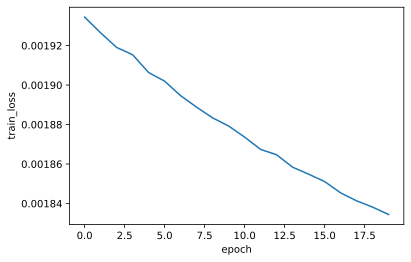

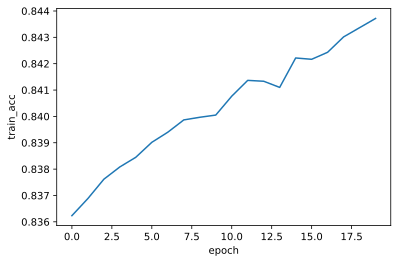

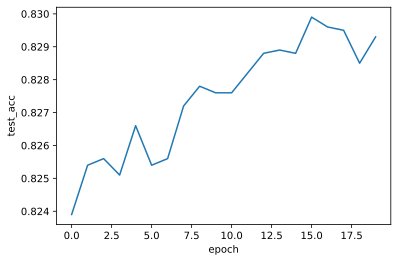

In [168]:
num_epochs = 20
train(net, train_iter, test_iter, criterion, num_epochs,batch_size, None, None, optimizer)

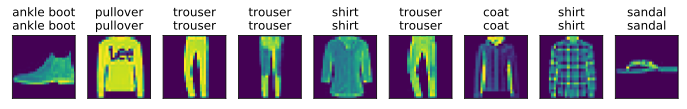

In [167]:
X, y = iter(test_iter).next()
true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels,pred_labels)]
d2l.show_fashion_mnist(X[0:9], titles[0:9])

## ptrorch知识点

### 1.torchvision的用法
1. torchvision.datasets : ⼀些加载数据的函数及常⽤的数据集接⼝；
2. torchvision.models : 包含常⽤的模型结构（含预训练模型），例如AlexNet、 VGG、
ResNet等；
3. torchvision.transforms : 常⽤的图⽚变换，例如裁剪、旋转等；
4. torchvision.utils : 其他的⼀些有⽤的⽅法    

### 2.torch对维度操作  
给定⼀个 Tensor 矩阵 X 。我们可以只对其中同⼀列（ dim=0 ）或同⼀⾏（ dim=1 ）的元素求
和，并在结果中保留⾏和列这两个维度（ keepdim=True ）

In [43]:
X = t.tensor([[1, 2, 3], [2, 5, 6]])
X

tensor([[1, 2, 3],
        [2, 5, 6]])

In [49]:
X.sum(dim=1)

tensor([ 6, 13])

In [50]:
# 0 列 保持维度
X.sum(dim=0, keepdim=True)

tensor([[3, 7, 9]])